In [2]:
%matplotlib inline

import numpy as np
import subprocess
import sys

import matplotlib.pyplot as plt

In [3]:
print(sys.executable)
print(sys.path)

/home/junxianh/anaconda3/envs/support/bin/python
['/projects/junxianh/sparse-prototype/noedit_analysis', '/home/junxianh/anaconda3/envs/support/lib/python37.zip', '/home/junxianh/anaconda3/envs/support/lib/python3.7', '/home/junxianh/anaconda3/envs/support/lib/python3.7/lib-dynload', '', '/home/junxianh/.local/lib/python3.7/site-packages', '/home/junxianh/anaconda3/envs/support/lib/python3.7/site-packages', '/projects/junxianh/support-prototype', '/projects/junxianh/sparse-prototype/fairseq_local', '/home/junxianh/anaconda3/envs/support/lib/python3.7/site-packages/IPython/extensions', '/home/junxianh/.ipython']


In [4]:
import faiss

In [5]:
def get_file_len(file):
    proc = subprocess.run(['wc', '-l', file], capture_output=True)
    return int(proc.stdout.decode('utf-8').split()[0])

In [8]:
import os
print(os.getcwd())

/projects/junxianh/sparse-prototype/noedit_analysis


In [9]:
template_size = get_file_len('../datasets/yelp_large_bpe/template.txt')
valid_size = get_file_len('../datasets/yelp_large_bpe/valid.txt')
emb_size = 768

In [26]:
template_emb = np.memmap('../precompute_embedding_datasets/yelp_large_bpe/yelp_large_bpe.sentbert.template.npy', 
                    dtype='float16', mode='r', shape=(template_size, emb_size))
valid_emb = np.memmap('../precompute_embedding_datasets/yelp_large_bpe/yelp_large_bpe.sentbert.valid.npy', 
                    dtype='float16', mode='r', shape=(valid_size, emb_size))

In [27]:
template_data = open('../datasets/yelp_large_bpe/template.txt').readlines()
valid_data = open('../datasets/yelp_large_bpe/valid.txt').readlines()

In [28]:
template_emb = np.array(template_emb).astype('float32')
print(template_emb)

[[-0.21130371 -0.01338196  0.5307617  ... -0.53271484 -0.03918457
  -0.29614258]
 [-0.25732422  0.02671814  1.1748047  ...  0.12109375 -0.30810547
   0.7871094 ]
 [-0.09039307  0.34057617  1.4755859  ...  0.71972656 -0.27734375
   0.2841797 ]
 ...
 [ 0.19921875  0.29907227  0.20544434 ...  0.64208984  0.42407227
   0.2109375 ]
 [-0.8041992   0.93847656  0.26538086 ...  0.13195801  0.12200928
  -0.09088135]
 [ 0.81933594  0.64990234  0.45141602 ... -0.25708008 -0.31958008
   0.1862793 ]]


In [29]:
valid_emb = np.array(valid_emb).astype('float32')

In [30]:
from sklearn.preprocessing import normalize
template_emb = normalize(template_emb, axis=1)

In [31]:
valid_emb = normalize(valid_emb, axis=1)

In [32]:
(template_emb * template_emb).sum(axis=1)

array([0.9999999 , 0.99999994, 1.0000002 , ..., 1.        , 1.        ,
       0.9999999 ], dtype=float32)

In [33]:
template_emb.shape

(100000, 768)

In [34]:
import faiss
index = faiss.IndexFlatIP(emb_size)
print(index.is_trained)
index.add(template_emb)                  # add vectors to the index
print(index.ntotal)

True
100000


In [35]:
D, I = index.search(valid_emb, 5) # sanity check

In [36]:
print(D)

[[0.7925476  0.79238915 0.79052603 0.78799057 0.78507817]
 [0.9085925  0.9029808  0.8988961  0.89215755 0.89167154]
 [0.92036927 0.9027685  0.89818484 0.89783216 0.89503366]
 ...
 [0.75926757 0.75683093 0.75237393 0.75205714 0.7511725 ]
 [0.9256618  0.92386377 0.91661    0.910743   0.90552545]
 [0.974928   0.94852996 0.9451724  0.93355584 0.9201683 ]]


In [37]:
print(I)

[[95238 87880 57042 42061 49706]
 [ 1688 44397 66679 28129 41701]
 [12665 13476 85531 12083 77450]
 ...
 [37789 89939 91219 26259 49408]
 [39362 19719 62399 74750 98084]
 [87730 65118 19099 80549 37688]]


In [38]:
print(I[1000])
print(D[1000])

[14972 55648 17331 19528 16967]
[0.8682054  0.8550117  0.83839893 0.83595216 0.83267117]


In [39]:
print(I[997])
print(D[997])
D[997].mean()

[98673 70975 27912  5900  9372]
[0.942031   0.92259324 0.91906476 0.90577376 0.8967124 ]


0.917235

In [40]:
from typing import List, Tuple
def _sim_to_id(sim: float, bin_bound: List[Tuple[int, int]]) -> str:
    """convert the length into the id of bucket, return the string of the id
    Args:
        length: the length to be converted
        bin_bound: the bucket denoted by a list of tuples
    """
    flag = False
    for i, bucket in enumerate(bin_bound):
        if sim >= bucket[0] and sim < bucket[1]:
            id_ = i
            flag = True
            break

    if not flag:
        raise ValueError("didn't find a bucket for sim {}".format(sim))

    return id_

In [41]:
def plot_ll_difference(scale='large'):
    def read_file(fname):
        res = {}
        with open(fname) as fin:
            for i, line in enumerate(fin):
                id_, tokens, ll = line.rstrip().split()
                id_ = int(id_)
                tokens = int(tokens)
                ll = float(ll)
                assert id_ not in res
                
                res[id_] = (tokens, ll)

        return res, len(res)
    
    data_prototype, _ = read_file(f'prototype/loss_yelp_bpe_{scale}.txt')
    data_lm, _ = read_file(f'lm/loss_yelp_bpe_{scale}.txt')
    
#     print(data_prototype)
    res = []
    for i in range(len(data_lm)):
        assert data_prototype[i][0] == data_lm[i][0]
        diff = (data_prototype[i][1] / data_prototype[i][0]) - (data_lm[i][1] / data_lm[i][0])
        res.append((D[i][0], data_prototype[i], data_lm[i]))
#         res.append((D[i][0], diff))

    all_sim = [x[0] for x in res]
    all_sim = sorted(all_sim)

    bucket_num = 10
    avg_bin_len = len(all_sim) // bucket_num
    bin_bound = []

    for i in range(bucket_num):
        if i == (bucket_num - 1):
            bin_bound.append((all_sim[i * avg_bin_len], 1.))
        else:
            bin_bound.append((all_sim[i * avg_bin_len], all_sim[(i+1) * avg_bin_len]))
            
    res_dict = {i: {'ntok': 0, 'll_prot': 0, 'll_lm':0} for i in range(len(bin_bound))}
    for x in res:
        id_ = _sim_to_id(x[0], bin_bound)
        res_dict[id_]['ntok'] += x[1][0]
        res_dict[id_]['ll_prot'] += x[1][1]
        res_dict[id_]['ll_lm'] += x[2][1]
        
    labels = [f'bucket {i}' for i in range(len(bin_bound))]
    prototype_ppl = [np.exp(-res_dict[i]['ll_prot'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]
    lm_ppl = [np.exp(-res_dict[i]['ll_lm'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width/2, prototype_ppl, width, label='protype')
    rects2 = ax.bar(x + width/2, lm_ppl, width, label='LM')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ppl')
    ax.set_title('ppl by different cos sim buckets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()
    
    return res

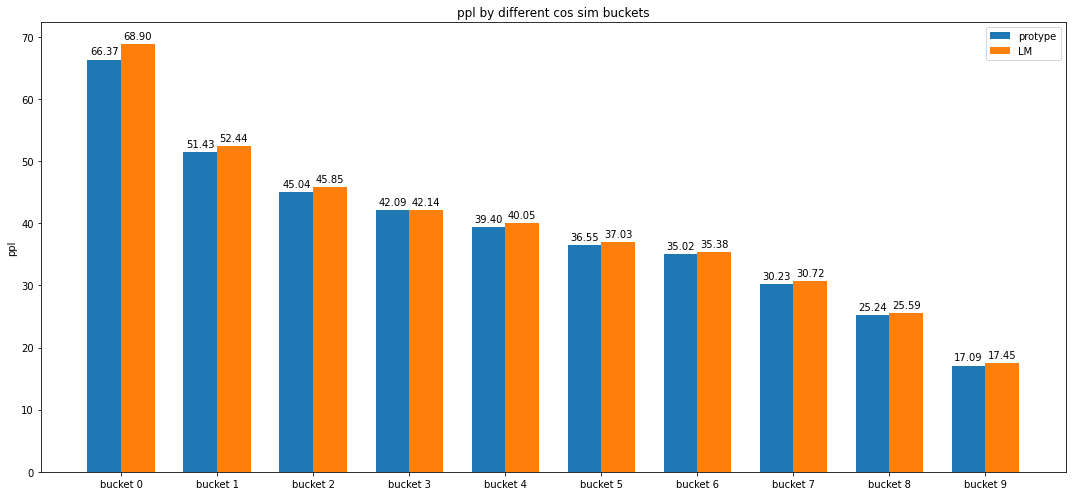

In [51]:
res = plot_ll_difference('medium')

In [54]:
def read_train_freq(file):
    from collections import Counter
    dict_ = Counter()
    with open(file) as fin:
        for line in fin:
            for word in line.strip().split():
                dict_[word] += 1
    return dict_

yelp_large_dict = read_train_freq('../datasets/yelp_large/train.txt')
yelp_large_dict['.']

14504196

In [55]:
def plot_ll_frequency(scale='large', dict_=None, word_freq=False):
    def read_file(fname):
        res = {}
        with open(fname) as fin:
            for i, line in enumerate(fin):
                id_, tokens, ll = line.rstrip().split()
                id_ = int(id_)
                tokens = int(tokens)
                ll = float(ll)
                assert id_ not in res
                
                res[id_] = (tokens, ll)

        return res, len(res)
    
    data_prototype, _ = read_file(f'prototype/loss_yelp_bpe_{scale}.txt')
    data_lm, _ = read_file(f'lm/loss_yelp_bpe_{scale}.txt')
    
    if dict_ is None:
        dict_ = {}
        with open(f'../data-bin/yelp_large_bpe/dict.txt') as fin:
            for line in fin:
                word, count = line.split()
                count = int(count)
                dict_[word] = count
            
#     template_data = open('../datasets/yelp_large/template.txt').readlines()
    valid_data = open('../datasets/yelp_large_bpe/valid.txt').readlines()
    
    oov = set()
    def get_minimum_freq(sentence):
        if word_freq:
            sentence = sentence.replace('@@ ', '')
            
        toks = sentence.strip().split()
        freqs = [dict_.get(tok, 0) for tok in toks]
        for freq, tok in zip(freqs, toks):
            if freq == 0:
                oov.update([tok])
        return min(freqs)
    
#     print(data_prototype)
    res = []
    for i in range(len(data_lm)):
        assert data_prototype[i][0] == data_lm[i][0]
        diff = (data_prototype[i][1] / data_prototype[i][0]) - (data_lm[i][1] / data_lm[i][0])
        res.append((get_minimum_freq(valid_data[i]), data_prototype[i], data_lm[i]))
#         res.append((D[i][0], diff))

#     print(oov)

    all_sim = [x[0] for x in res]
    all_sim = sorted(all_sim)

    bucket_num = 10
    avg_bin_len = len(all_sim) // bucket_num
    bin_bound = []

    for i in range(bucket_num):
        if i == (bucket_num - 1):
            bin_bound.append((all_sim[i * avg_bin_len], 1e8))
        else:
            bin_bound.append((all_sim[i * avg_bin_len], all_sim[(i+1) * avg_bin_len]))
            
#     bin_bound = [(0, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]
    print(bin_bound)
    res_dict = {i: {'ntok': 0, 'll_prot': 0, 'll_lm':0} for i in range(len(bin_bound))}
    for x in res:
        id_ = _sim_to_id(x[0], bin_bound)
        res_dict[id_]['ntok'] += x[1][0]
        res_dict[id_]['ll_prot'] += x[1][1]
        res_dict[id_]['ll_lm'] += x[2][1]
    
#     print(res_dict)
        
    labels = [f'bucket {i}' for i in range(len(bin_bound))]
    prototype_ppl = [np.exp(-res_dict[i]['ll_prot'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]
    lm_ppl = [np.exp(-res_dict[i]['ll_lm'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width/2, prototype_ppl, width, label='protype')
    rects2 = ax.bar(x + width/2, lm_ppl, width, label='LM')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ppl')
    ax.set_title('ppl by different frequency buckets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()
    
#     return res

[(6, 508), (508, 846), (846, 1493), (1493, 2506), (2506, 4286), (4286, 6894), (6894, 11514), (11514, 20124), (20124, 39229), (39229, 100000000.0)]


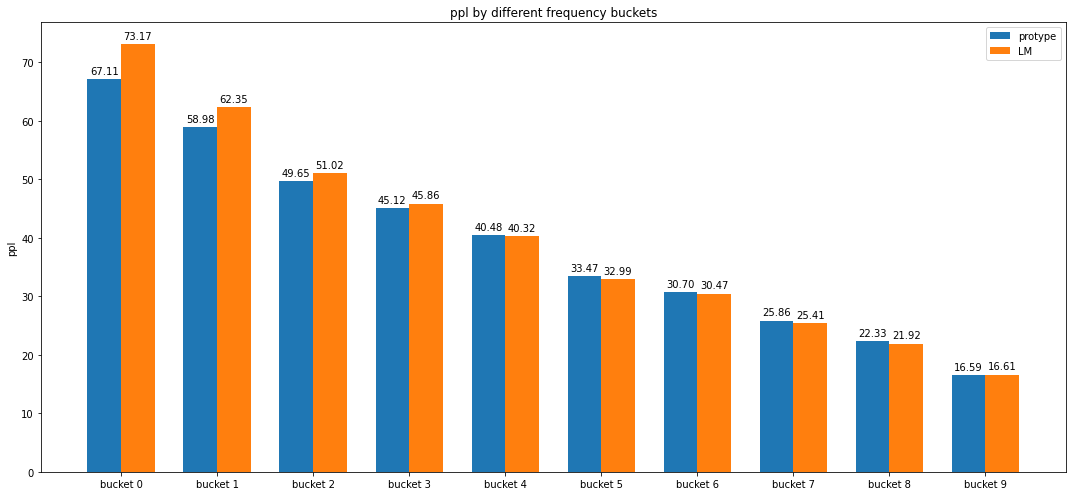

In [56]:
plot_ll_frequency('medium')

[(0, 93), (93, 429), (429, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]


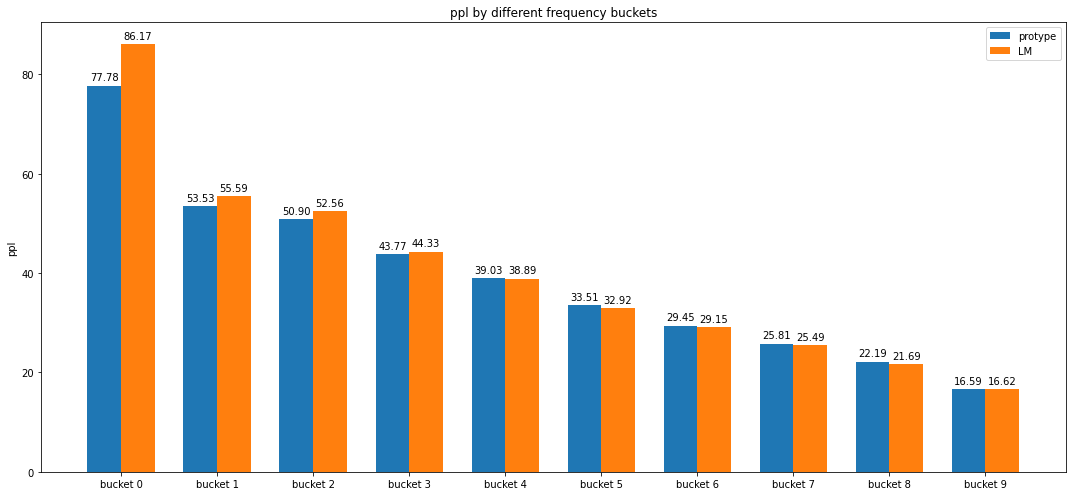

In [57]:
plot_ll_frequency('medium', yelp_large_dict, word_freq=True)

In [97]:
def compute_heat_map(scale='large', dict_=None, word_freq=False):
    def read_file(fname):
        res = {}
        with open(fname) as fin:
            for i, line in enumerate(fin):
                id_, tokens, ll = line.rstrip().split()
                id_ = int(id_)
                tokens = int(tokens)
                ll = float(ll)
                assert id_ not in res
                
                res[id_] = (tokens, ll)

        return res, len(res)
    
    data_prototype, _ = read_file(f'prototype/loss_yelp_bpe_{scale}.txt')
    data_lm, _ = read_file(f'lm/loss_yelp_bpe_{scale}.txt')
    
    if dict_ is None:
        dict_ = {}
        with open(f'../data-bin/yelp_large_bpe/dict.txt') as fin:
            for line in fin:
                word, count = line.split()
                count = int(count)
                dict_[word] = count
            
#     template_data = open('../datasets/yelp_large/template.txt').readlines()
    valid_data = open('../datasets/yelp_large_bpe/valid.txt').readlines()
    
    oov = set()
    def get_minimum_freq(sentence):
        if word_freq:
            sentence = sentence.replace('@@ ', '')
            
        toks = sentence.strip().split()
        freqs = [dict_.get(tok, 0) for tok in toks]
        for freq, tok in zip(freqs, toks):
            if freq == 0:
                oov.update([tok])
        return min(freqs)
    
#     print(data_prototype)
    res = []
    for i in range(len(data_lm)):
        assert data_prototype[i][0] == data_lm[i][0]
        diff = (data_prototype[i][1] / data_prototype[i][0]) - (data_lm[i][1] / data_lm[i][0])
        res.append((D[i][0], get_minimum_freq(valid_data[i]), data_prototype[i], data_lm[i]))
#         res.append((D[i][0], diff))

#     print(oov)
    def get_bound(xs, bucket_num=10):
        xs = sorted(xs)
        avg_bin_len = len(xs) // bucket_num
        bin_bound = []
        for i in range(bucket_num):
            if i == (bucket_num - 1):
                bin_bound.append((xs[i * avg_bin_len], 1e8))
            else:
                bin_bound.append((xs[i * avg_bin_len], xs[(i+1) * avg_bin_len]))
                
        return bin_bound
    
#     import pdb;pdb.set_trace()
    sim_bound = get_bound([x[0] for x in res])
    freq_bound = get_bound([x[1] for x in res])
            
    print(f'sim buckets {sim_bound}')
    print(f'freq buckets {freq_bound}')
    res_dict = {(i, j): {'ntok': 0, 'll_prot': 0, 'll_lm':0, 'num_example':0} \
                for i in range(len(freq_bound)) for j in range(len(sim_bound))}
    per_example = {(i, j): [] \
                for i in range(len(freq_bound)) for j in range(len(sim_bound))}
    for k, x in enumerate(res):
        id_freq = _sim_to_id(x[1], freq_bound)
        id_sim = _sim_to_id(x[0], sim_bound)
        res_dict[(id_freq, id_sim)]['ntok'] += x[2][0]
        res_dict[(id_freq, id_sim)]['ll_prot'] += x[2][1]
        res_dict[(id_freq, id_sim)]['ll_lm'] += x[3][1]
        res_dict[(id_freq, id_sim)]['num_example'] += 1
        
        per_example[(id_freq, id_sim)].append({'id': k, 
                                               'knn_id': I[k][0], 
                                               'sim': x[0],
                                               'freq': x[1],
                                               'avg_gain': (x[2][1] - x[3][1]) / x[2][0]
                                              })
    
    heat_map = np.zeros((len(sim_bound),len(freq_bound)))
    heat_map_cnt = np.zeros((len(sim_bound),len(freq_bound)))
    
    for i in range(len(freq_bound)):
        for j in range(len((sim_bound))):
            prototype_ppl = np.exp(-res_dict[(i, j)]['ll_prot'] / res_dict[(i, j)]['ntok'])
            lm_ppl = np.exp(-res_dict[(i, j)]['ll_lm'] / res_dict[(i, j)]['ntok'])
            heat_map[j, i] = lm_ppl - prototype_ppl
            heat_map_cnt[j, i] = res_dict[(i, j)]['num_example']
            
    return heat_map, heat_map_cnt, per_example
            

In [78]:
def plot_heat_map(heat_map):
#     print(res_dict)
#     import pdb;pdb.set_trace()
    fig, ax = plt.subplots(figsize=(7, 7))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('embedding similarity')
    ax.set_xlabel('frequency')
    ax.set_title('ppl by different frequency buckets')
   
    ax.imshow(heat_map)
    nrows, ncols = heat_map.shape
    
    for i in range(ncols):
        for j in range(nrows):
            text = ax.text(i, j, f'{heat_map[j, i]:.1f}', 
                          ha="center", va="center", color="w")
    
    fig.tight_layout()

    plt.show()
    
#     return res

In [94]:
def show_salient_example(xs, template_text, data_text, ns=10):
    from collections import OrderedDict
    import pandas as pd
    pd_data = OrderedDict([('avg_gain', []), ('data', []), ('template', []), ('freq', []), ('sim', [])])
    xs_sort = sorted(xs, key=lambda x: -x['avg_gain'])

    for i in range(ns):
        pd_data['data'].append(data_text[xs_sort[i]['id']].strip())
        pd_data['template'].append(template_text[xs_sort[i]['knn_id']].strip())
        pd_data['freq'].append(xs_sort[i]['freq'])
        pd_data['avg_gain'].append(xs_sort[i]['avg_gain'])
        pd_data['sim'].append(xs_sort[i]['sim'])
        
    pd_data = pd.DataFrame(pd_data)
    
    def left_align(df):
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
            [dict(selector='th', props=[('text-align', 'left')])]
        )
        return left_aligned_df
    
    with pd.option_context('display.max_rows', None, 
                           'display.max_columns', None, 
                           "display.max_colwidth", -1):
        display(left_align(pd_data))
    

In [92]:
template_text = open('../datasets/yelp_large_bpe/template.txt').readlines()
data_text = open('../datasets/yelp_large_bpe/valid.txt').readlines()

In [104]:
heat_map, heat_map_cnt, per_example = compute_heat_map(scale='medium', dict_=yelp_large_dict, word_freq=True)

sim buckets [(0.58204484, 0.7721474), (0.7721474, 0.8012194), (0.8012194, 0.82033944), (0.82033944, 0.8370192), (0.8370192, 0.85235894), (0.85235894, 0.8678297), (0.8678297, 0.8842226), (0.8842226, 0.90299654), (0.90299654, 0.92710507), (0.92710507, 100000000.0)]
freq buckets [(0, 93), (93, 429), (429, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]


In [106]:
show_salient_example(per_example[(0,9)], template_text, data_text)

,avg_gain,data,template,freq,sim
0,1.236804,"i m ging das alles , aber ab@@ ges@@ e@@ hen von den man da nichts ein@@ z@@ el@@ nd k@@ auf@@ en .","um@@ so ger@@ ner ge@@ ht man un@@ ter der , da ist auch die ent@@ sp@@ ann@@ ter .",0,0.945977
1,1.055513,i highly recommend be@@ cks .,i highly recommend j@@ ts !,6,0.929598
2,0.782285,"their wine list was particularly impressive , but a@@ sin@@ inely expensive .","unfortunately , their wine selection , while lovely , is outrageously expensive .",1,0.948845
3,0.755430,"none of our belongings were da@@ managed nor was there any damage to our walls , etc .","not one single ding , dent or scratch on any of our belongings .",0,0.947133
4,0.676219,i had the chan@@ clas@@ - shredded marinated chicken on bo@@ le@@ tto buns with fresh sliced avocado and onion in a char@@ ro broth .,"i opted for chicken breast , tomatoes , onions , and garlic sauce , wrapped in la@@ vo@@ sh bread and wood - fired , served with a greek salad .",0,0.953046
5,0.648029,this hospital is the worst i have ever vi@@ sted .,this has been the worst visit that i have had at an urgent care .,81,0.940866
6,0.616880,i do n't think i wil@@ ll be back soon .,i do n't think i will be back any time soon .,38,0.955788
7,0.611368,i got the white macadamia cooki@@ e/@@ chocolate chip cookie with cookies and cream icecream ...,i had the warm chocolate torte with vanilla ice cream and my had the bread pudding .,1,0.942171
8,0.600092,c'est un peu particu@@ lier .,ne pas se fier aux apparen@@ ces .,60,0.934468
9,0.522208,und so tu@@ n als wür@@ den sie ger@@ ade das sch@@ u@@ tz@@ gel@@ d ab@@ hol@@ en .,b. i m mol@@ ker@@ ei@@ - und fi@@ sch@@ bere@@ ich ) und leider be@@ s@@ ser@@ t sich das nicht .,0,0.947077


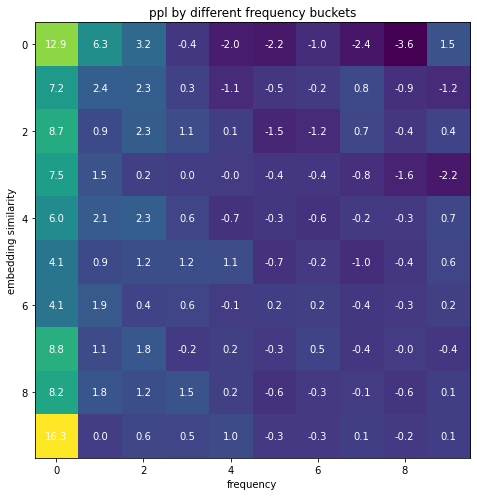

In [107]:
plot_heat_map(heat_map)

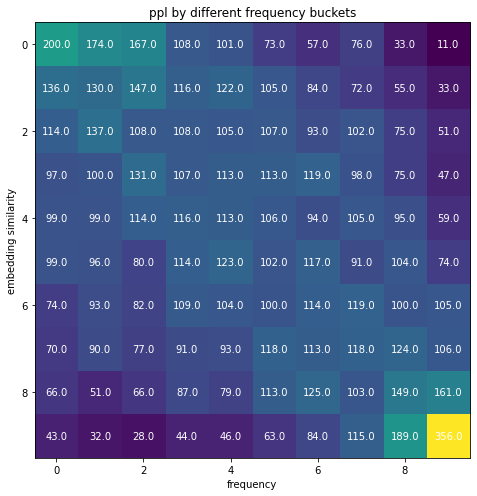

In [81]:
plot_heat_map(heat_map_cnt)

In [109]:
heat_map, heat_map_cnt, _ = compute_heat_map(scale='large', dict_=yelp_large_dict, word_freq=True)

sim buckets [(0.58204484, 0.7721474), (0.7721474, 0.8012194), (0.8012194, 0.82033944), (0.82033944, 0.8370192), (0.8370192, 0.85235894), (0.85235894, 0.8678297), (0.8678297, 0.8842226), (0.8842226, 0.90299654), (0.90299654, 0.92710507), (0.92710507, 100000000.0)]
freq buckets [(0, 93), (93, 429), (429, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]


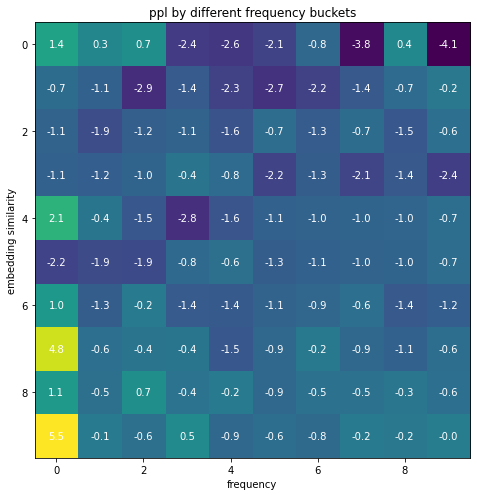

In [110]:
plot_heat_map(heat_map)